# Comparison of Amplitudes

This notebook compares the amplitudes as defined in `d02kspipi_toys` from Jordi Garra Tico and those defined in `AmpliTF`.

In [1]:
import numpy as np
import amplitf.interface as atfi
import amplitf.dynamics as atfd
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace
import matplotlib.pyplot as plt
import tfa.plotting as tfp

2025-05-08 11:34:25.282055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746696865.301315  355332 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746696865.307255  355332 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746696865.322768  355332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746696865.322788  355332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746696865.322790  355332 computation_placer.cc:177] computation placer alr

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


I0000 00:00:1746696867.620404  355332 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46761 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


In [2]:
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)

Plotting sample from D0->Ksππ phase space.

In [3]:
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)
nnorm=100000
norm_sample = phsp.uniform_sample(nnorm)

## Breit-Wigner

Jordi Garra Tico's amplitude is defined as:

$$
\begin{align}
BW(m) &= f_R f_D \frac{1}{(m_0^2 - m^2) + i m_0 \Gamma(m)} \Omega\\
\Gamma(m) &= \Gamma_0 \left(\frac{p}{p_0}\right)^3 \frac{m_0}{m} f_R^2 \\
f_R &= \sqrt{\frac{1+R_r^2p_0^2}{1+R_r^2p^2}} \quad \text{with} \quad R_r = 1.5 \\
f_D &= \sqrt{\frac{1+R_D^2 p_{D,0}^2}{1+R_D^2p_D^2}} \quad \text{with} \quad R_D = 5.0 \\
p &= \sqrt{\frac{(m^2-m_A^2-m_B^2)^2 - 4 m_A^2 m_B^2}{4 m^2}}\\
p_R &= \sqrt{\frac{(m_0^2-m_A^2-m_B^2)^2 - 4m_A^2m_B^2}{4 m_0^2}}\\
p_{D,0} &= \sqrt{\frac{(m_D^2-m_0^2-m_C^2)^2 - 4m_0^2*m_C^2}{4m_D^2}}\\
p_D &= \sqrt{\frac{(m_D^2-m^2-m_C^2)^2 - 4m^2*m_C^2}{4m_D^2}}\\
\Omega &= m_{AC}^2-m_{BC}^2+\frac{(m_D^2-m_C^2)(m_B^2-m_A^2)}{m^2}
\end{align}
$$


In [4]:
pi180inv = np.pi / 180.

def helicity(mAB,mBC,mAC,mA,mB,mC,mD,spin):
    hel = np.where( spin==1, mAC*mAC-mBC*mBC+((mD*mD-mC*mC)*(mB*mB-mA*mA)/(mAB*mAB)),
                  np.where( spin==2, np.power(mBC*mBC-mAC*mAC+(mD*mD-mC*mC)*(mA*mA-mB*mB)/(mAB*mAB),2)-
                                    1./3.*(mAB*mAB-2.*(mD*mD+mC*mC)+np.power(mD*mD-mC*mC,2)/(mAB*mAB))*
                                    (mAB*mAB-2.*(mA*mA+mB*mB)+pow(mA*mA-mB*mB,2)/(mAB*mAB)),
                             1.0) )    
    return hel

def amplitude_BW(v1, v2, v3,
                 _amp, _phase, _gammaR, _massR, _spinR,
                 _ma, _mb, _mc, mD0):
    ampl=_amp
    theta=_phase

    gamma = _gammaR
    bwm = _massR
    spin = _spinR

    R_r = 1.5 # "resonance radius" for Blatt-Weisskoper barrier factors.
    R_D = 5.0 # "D meson radius" for Blatt-Weisskoper barrier factors.

    mAB=np.sqrt(v1) # = (_p4_d1+_p4_d2).mass();
    mBC=np.sqrt(v2) # = (_p4_d2+p4_d3).mass();
    mAC=np.sqrt(v3) # = (_p4_d1+p4_d3).mass();

    mA=_ma # = _p4_d1.mass();
    mB=_mb # = _p4_d2.mass();
    mC=_mc # = _p4_d3.mass();
    mD=mD0 # = _p4_p.mass();    
    
    mR=bwm
    gammaR=gamma

    pAB=np.sqrt((((mAB*mAB-mA*mA-mB*mB)*(mAB*mAB-mA*mA-mB*mB)/4.0) - mA*mA*mB*mB)/(mAB*mAB))
    pR=np.sqrt((((mR*mR-mA*mA-mB*mB)*(mR*mR-mA*mA-mB*mB)/4.0) - mA*mA*mB*mB)/(mR*mR))

    pD=(((mD*mD-mR*mR-mC*mC)*(mD*mD-mR*mR-mC*mC)/4.0) - mR*mR*mC*mC)/(mD*mD)
    pD=np.where(pD>0, np.sqrt(pD), 0.)
    pDAB=np.sqrt( (((mD*mD-mAB*mAB-mC*mC)*(mD*mD-mAB*mAB-mC*mC)/4.0) - mAB*mAB*mC*mC)/(mD*mD))

    # Compute Blatt-Weisskopf barrier factors.
    fR= np.where( spin == 1, np.sqrt(1.0+R_r*R_r*pR*pR)/np.sqrt(1.0+R_r*R_r*pAB*pAB),
                  np.where( spin == 2, np.sqrt(9.0+3.0*R_r*R_r*pR*pR+R_r*R_r*pR*pR*R_r*R_r*pR*pR)/np.sqrt(9.0+3.0*R_r*R_r*pAB*pAB+R_r*R_r*pAB*pAB*R_r*R_r*pAB*pAB), 
                            1.0) )
    fD= np.where( spin == 1, np.sqrt(1.0+R_D*R_D*pD*pD)/np.sqrt(1.0+R_D*R_D*pDAB*pDAB),
                  np.where( spin == 2, np.sqrt(9.0+3.0*R_D*R_D*pD*pD+R_D*R_D*pD*pD*R_D*R_D*pD*pD)/np.sqrt(9.0+3.0*R_D*R_D*pDAB*pDAB+R_D*R_D*pDAB*pDAB*R_D*R_D*pDAB*pDAB), 
                            1.0) )
    power= np.where( spin == 1, 3.0,
                  np.where( spin == 2, 5.0, 1.0) )
    
    # Compute the running width.
    gammaAB= gammaR*np.power(pAB/pR,power)*(mR/mAB)*fR*fR

    # Compute the amplitude.
    matrixEl = np.where( spin==1, mAC*mAC-mBC*mBC+((mD*mD-mC*mC)*(mB*mB-mA*mA)/(mAB*mAB)),
                  np.where( spin==2, np.power(mBC*mBC-mAC*mAC+(mD*mD-mC*mC)*(mA*mA-mB*mB)/(mAB*mAB),2)-
                                    1./3.*(mAB*mAB-2.*(mD*mD+mC*mC)+np.power(mD*mD-mC*mC,2)/(mAB*mAB))*
                                    (mAB*mAB-2.*(mA*mA+mB*mB)+pow(mA*mA-mB*mB,2)/(mAB*mAB)),
                             1.0) )
    matrixEl = matrixEl*ampl*complex(np.cos(theta*pi180inv),np.sin(theta*pi180inv))*fR*fD/(mR*mR-mAB*mAB-mR*gammaAB*1j)

    return matrixEl

In [5]:
mkst = atfi.const(0.890)
wkst = atfi.const(0.050)
rd = atfi.const(5.0)
rr = atfi.const(1.5)
aBW = amplitude_BW(phsp.m2ab(norm_sample),
                   phsp.m2bc(norm_sample),
                   phsp.m2ac(norm_sample),
                   1.0,  # amplitude
                   0.0,  # phase
                   wkst.numpy(), # gammaR
                   mkst.numpy(), # massR
                   1,    # spinR
                   mpi.numpy(), # mA
                   mkz.numpy(), # mB
                   mpi.numpy(), # mC
                   md.numpy())   # mD0
aBW_tf = atfd.breit_wigner_lineshape(phsp.m2ab(norm_sample), mkst, wkst, mpi, mkz, mpi, md, rd,
                                      rr, 1, 1) * \
         atfd.helicity_amplitude(phsp.cos_helicity_ab(norm_sample), 1)

In [6]:
hel = helicity(np.sqrt(phsp.m2ab(norm_sample)),np.sqrt(phsp.m2bc(norm_sample)), np.sqrt(phsp.m2ac(norm_sample)), 
               mpi.numpy(),mkz.numpy(), mpi.numpy(), md.numpy(), 1)
hel_tf = atfd.helicity_amplitude(phsp.cos_helicity_ab(norm_sample), 1) 

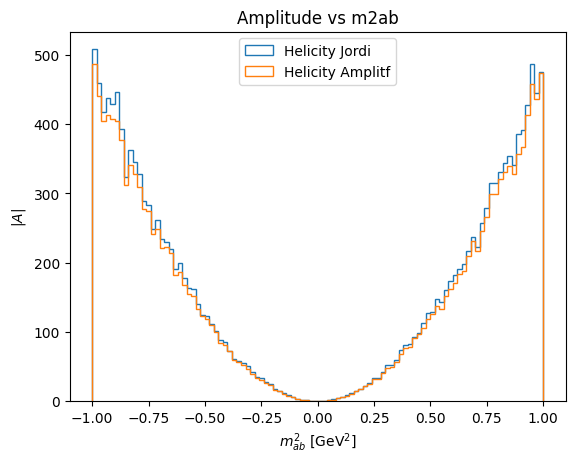

In [7]:
plt.hist(phsp.cos_helicity_ab(norm_sample), weights = 0.5*np.power(np.abs(hel),2), bins=100, histtype='step', label='Helicity Jordi')
plt.hist(phsp.cos_helicity_ab(norm_sample), weights = atfd.density(hel_tf), bins=100, histtype='step', label='Helicity Amplitf')
plt.xlabel(r'$m_{ab}^2$ [GeV$^2$]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m2ab')
plt.legend()

The normalisation of the helicity amplitude is different between the two definitions.
Let's plot the helicity amplitudes for various spins from AmpliTF

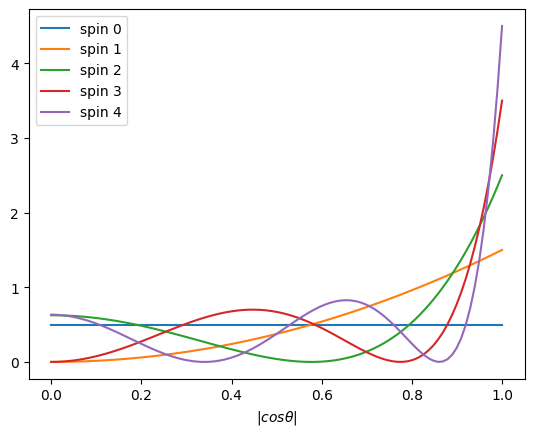

In [13]:
x_pl = np.linspace(0, 1, 100)
plt.plot(x_pl, atfd.density(atfd.helicity_amplitude(atfi.const(x_pl),0)*atfi.cast_complex(atfi.sqrt(1.0/2.0))), label='spin 0')
plt.plot(x_pl, atfd.density(atfd.helicity_amplitude(x_pl,1)*atfi.cast_complex(atfi.sqrt(3.0/2.0))), label='spin 1')
plt.plot(x_pl, atfd.density(atfd.helicity_amplitude(x_pl,2)*atfi.cast_complex(atfi.sqrt(5.0/2.0))), label='spin 2')
plt.plot(x_pl, atfd.density(atfd.helicity_amplitude(x_pl,3)*atfi.cast_complex(atfi.sqrt(7.0/2.0))), label='spin 3')
plt.plot(x_pl, atfd.density(atfd.helicity_amplitude(x_pl,4)*atfi.cast_complex(atfi.sqrt(9.0/2.0))), label='spin 4')
plt.xlabel(r'$|cos\theta|$')
plt.legend()

To work with normalised helicity amplitudes, one needs to multiply the amplitude by $\sqrt{\frac{2n+1}{2}}$

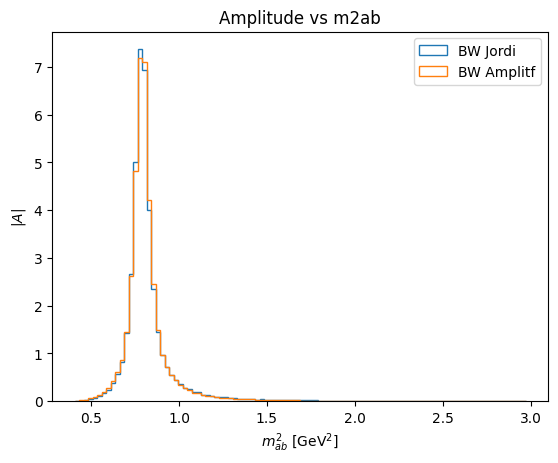

In [14]:
plt.hist(phsp.m2ab(norm_sample), weights = np.power(np.abs(aBW),2), bins=100, histtype='step', label='BW Jordi', density=True)
plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(aBW_tf), bins=100, histtype='step', label='BW Amplitf', density=True)
plt.xlabel(r'$m_{ab}^2$ [GeV$^2$]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m2ab')
plt.legend()

The shapes are relatively similar, but the normalisation is different.

In [21]:
sum_aBW = np.power(np.abs(aBW),2).sum()
sum_aBW_tf = atfi.sum(atfd.density(aBW_tf)).numpy()
print(sum_aBW, sum_aBW_tf)
print(sum_aBW/sum_aBW_tf)
print(np.sqrt(sum_aBW/sum_aBW_tf))

1625580.727868822 563910.0159188014
2.8826952562993537
1.6978501866476188


In [8]:
m2ab_bounds = (phsp.bounds()[0][0].numpy(), phsp.bounds()[0][1].numpy())

[]

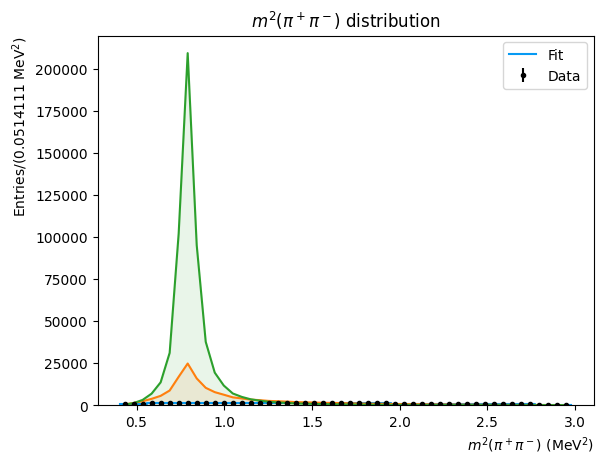

In [9]:
fig, ax = plt.subplots()
tfp.plot_distr1d_comparison(
    phsp.m2ab(norm_sample),
    phsp.m2ab(norm_sample),
    cweights=[np.abs(aBW),atfd.density(aBW_tf)],
    bins=50,
    range=m2ab_bounds,
    ax=ax,
    label=r"$m^2(\pi^+\pi^-)$",
    units="MeV$^2$",
)

## LASS

## K-matrix